Stock Price Prediction Using XGBoost and Technical Indicators

Introduction:

This kernel demonstrates the utilization of XGBRegressor from the XGBoost library to forecast future stock prices by employing technical indicators as features. If you seek explanations for the indicators employed in this analysis, such as moving averages, RSI, and MACD, I recommend referring to articles on Investopedia or exploring my accompanying notebook, where I introduce and visually illustrate different concepts of technical analysis.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ksedataset/PKSLC.csv
/kaggle/input/ksedataset/IBLHL.csv
/kaggle/input/ksedataset/JOVC.csv
/kaggle/input/ksedataset/PIBTL.csv
/kaggle/input/ksedataset/FATIMA.csv
/kaggle/input/ksedataset/FECTC.csv
/kaggle/input/ksedataset/PGHE.csv
/kaggle/input/ksedataset/ICPXXIV.csv
/kaggle/input/ksedataset/SRSM.csv
/kaggle/input/ksedataset/DSML.csv
/kaggle/input/ksedataset/KCORP.csv
/kaggle/input/ksedataset/ICIBL.csv
/kaggle/input/ksedataset/OLPL.csv
/kaggle/input/ksedataset/BNWM.csv
/kaggle/input/ksedataset/CSAP.csv
/kaggle/input/ksedataset/CHBL.csv
/kaggle/input/ksedataset/DICL.csv
/kaggle/input/ksedataset/FFL.csv
/kaggle/input/ksedataset/KSE-MI30.csv
/kaggle/input/ksedataset/GTYR.csv
/kaggle/input/ksedataset/ABOT.csv
/kaggle/input/ksedataset/GLAXO.csv
/kaggle/input/ksedataset/NORS.csv
/kaggle/input/ksedataset/CSIBL.csv
/kaggle/input/ksedataset/PMRS.csv
/kaggle/input/ksedataset/RMCP.csv
/kaggle/input/ksedataset/QUICE.csv
/kaggle/input/ksedataset/AGIL.csv
/kaggle/input/ksedataset/PREMA.

This code snippet performs several tasks related to data processing and file handling. 

First, it imports the numpy library and assigns it the alias "np." Numpy is a popular library for numerical computations in Python, providing support for arrays and matrices. Similarly, it imports the pandas library and assigns it the alias "pd." Pandas is a powerful data manipulation and analysis tool, widely used for handling structured data.

Next, the code imports the os module, which provides a way to interact with the operating system. It is used here for file and directory handling tasks. 

The code then utilizes a for loop combined with the os.walk() function to traverse a directory ("/kaggle/input") and its subdirectories, retrieving information about each file within them. Within the loop, another for loop iterates over the list of filenames obtained from the os.walk() function call.

For each filename, the code prints the complete path to the file by joining the directory name and the filename using the os.path.join() function. This step serves as a diagnostic process to check and verify the availability of files in the specified directory.

Finally, a comment states that any results written to the current directory will be saved as output.

In summary, this code imports necessary libraries, searches for files in a specific directory, and prints their paths. It also provides a reminder about where the output will be saved.

In [2]:
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


#!pip install numpy scipy patsy pandas
#!pip install statsmodels
# Time series decomposition
#!pip install stldecompose
#from stldecompose import decompose
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,1,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

print(os.listdir("../input"))

['ksedataset']


This code snippet includes various import statements and configuration settings for several Python libraries and modules.

First, it imports the xgboost library and assigns it the alias "xgb." XGBoost is a popular machine learning library used for gradient boosting.

Next, it imports the matplotlib.pyplot module and assigns it the alias "plt." Matplotlib is a widely used plotting library in Python.

The code also imports specific components from xgboost, such as plot_importance and plot_tree, which are used for visualizing feature importances and decision trees generated by XGBoost models.

Furthermore, it imports several components from the scikit-learn library, including mean_squared_error for evaluating regression models, MinMaxScaler for scaling numerical features, train_test_split for splitting data into training and testing sets, and GridSearchCV for hyperparameter tuning using cross-validation.

The code then installs certain packages by using the "!pip install" syntax. These packages include numpy, scipy, patsy, pandas, and statsmodels. These packages provide various statistical and data manipulation functionalities.

Additionally, it installs the stldecompose package for time series decomposition and imports the decompose function from this package.

For chart drawing and visualization, the code imports components from the plotly library and assigns them appropriate aliases. Plotly is a library used for interactive and visually appealing plots.

Next, the code mutes warnings from scikit-learn to avoid cluttering the output.

To display charts in the current kernel environment, it initializes the plotly notebook mode.

The code also modifies the default background color for visualizations by defining a custom layout using plotly.graph_objects.

Finally, the code prints the list of files in the "../input" directory to verify the available files.

In summary, this code snippet sets up the necessary imports, configurations, and installations of libraries and modules used for machine learning, plotting, statistical analysis, and data manipulation.

To begin the analysis, I read the historical data frame for a specific stock (e.g., CERN) that I intend to examine. The dataset obtained is sourced from the New York Stock Exchange and encompasses day-by-day price history spanning over a period of more than 10 years.

In order to streamline the data processing and analysis, I made the decision to narrow down the time frame and focus on data starting from the year 2010. This helps to reduce the amount of data that needs to be processed, enabling a more manageable dataset for further analysis.

Subsequently, I removed the rows of data that fall outside the desired time frame. This step ensures that only the relevant data from the chosen time period remains for analysis.

Finally, I reindexed the data frame to maintain a clean and organized structure. This reindexing operation allows for a consistent and sequential arrangement of the data, facilitating easier access and manipulation during subsequent analysis steps.

In [3]:
df= pd.read_csv("../input/ksedataset/FATIMA.csv")
df.head()

Symbol         Date   Open   High    Low  Close    Volume
0  FATIMA  08-Mar-2010  12.93  13.59  12.85  13.34  20170750
1  FATIMA  09-Mar-2010  13.48  13.48  12.90  13.00   2694829
2  FATIMA  10-Mar-2010  13.10  13.19  12.71  12.77   1168442
3  FATIMA  11-Mar-2010  12.95  13.20  12.61  12.69   3115052
4  FATIMA  12-Mar-2010  12.87  12.88  12.50  12.56   1400592

This code snippet performs two main operations on a dataset. 

First, it reads a CSV file using the pandas library. The file path provided is "../input/ksedataset/FATIMA.csv". By utilizing the pandas "read_csv()" function, the code imports the contents of the CSV file into a pandas DataFrame. A DataFrame is a tabular data structure that allows for efficient manipulation and analysis of the data.

After reading the CSV file and creating the DataFrame, the code uses the DataFrame's "head()" method. This method displays the first few rows of the dataset. By default, it shows the top five rows, giving a concise overview of the data.

This preview of the data is helpful for understanding the structure of the dataset and examining the initial values in each column. It allows for a quick assessment of the column names, data types, and a sample of the actual values contained within the dataset.

In summary, the code reads a CSV file into a pandas DataFrame and then displays the initial rows of the dataset. This provides an initial glimpse of the data's structure and content, facilitating the subsequent analysis and exploration of the dataset.

To gain insights into historical prices, I begin by creating an OHLC (open/high/low/close) chart. This chart visually represents the four essential data points for each trading day: the opening price, the highest price, the lowest price, and the closing price. By plotting these data points, I can observe the price movements and patterns over the historical period.

In addition to the OHLC chart, I also create a Volume chart. This chart depicts the number of stocks traded on each day. By visualizing the volume of trading activity, I can assess the level of market participation and identify potential trends or anomalies.

In a previous notebook (referenced above), I delve into the significance of OHLC and Volume charts in technical analysis. This analysis provides a comprehensive understanding of how these charts are utilized to interpret market behavior, identify support and resistance levels, and make informed trading decisions.

Overall, the code generates an OHLC chart to visualize historical prices and a Volume chart to represent trading activity. These charts serve as valuable tools for technical analysis, providing insights into price movements and market dynamics.

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

This code snippet creates a visual representation of data using the Plotly library. It generates a figure with two subplots arranged vertically (two rows and one column) to display an OHLC (open/high/low/close) chart and a Volume chart.

In the first subplot, an OHLC chart is added using the go.Ohlc trace type from Plotly. The x-axis values for the OHLC chart are taken from the "Date" column of the DataFrame "df". The open, high, low, and close values for each data point are obtained from the corresponding columns in the DataFrame. The resulting OHLC chart provides a graphical representation of the price movements over time.

In the second subplot, a Scatter plot is added using the go.Scatter trace type. The x-axis values are again taken from the "Date" column, and the y-axis values are taken from the "Volume" column of the DataFrame. This Volume chart displays the trading volume, representing the number of stocks traded on each day.

After adding the traces to the subplots, the code updates the layout of the figure. In particular, it sets the rangeslider of the x-axis to be invisible, removing the interactive slider that allows zooming and panning along the x-axis.

Finally, the code displays the generated figure using the "show()" method. This will render the figure with the OHLC chart and Volume chart, allowing for visual analysis and interpretation of the historical price and trading volume data.

In summary, this code generates a figure with two subplots: an OHLC chart representing price movements and a Volume chart showing trading volume. The resulting figure provides a visual representation of the data, aiding in the analysis of historical price trends and trading activity.

Decomposition

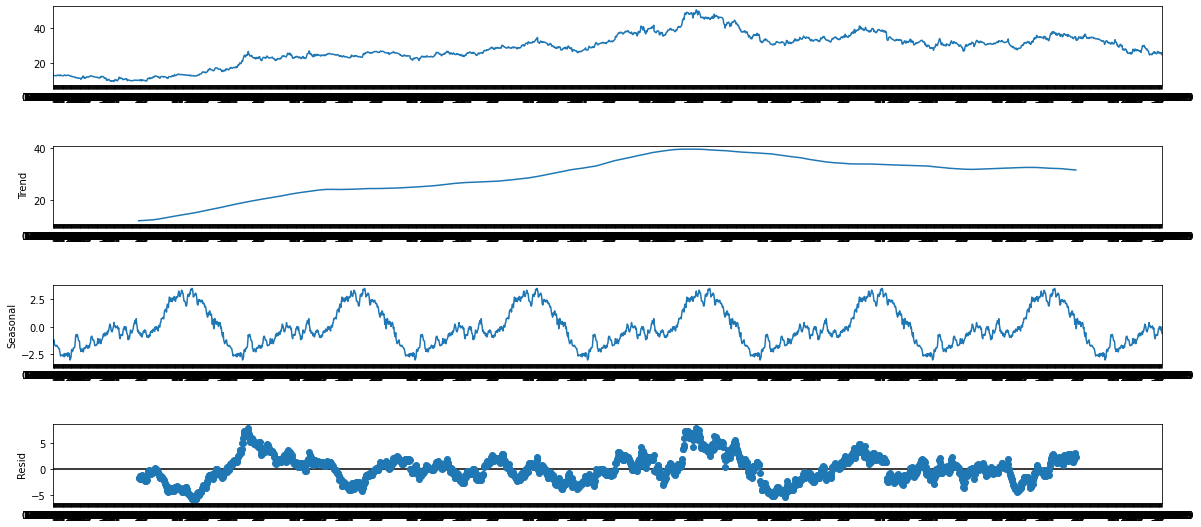

In [5]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = seasonal_decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

This code performs a time series decomposition and generates a plot to visualize the decomposed components. 

First, a new DataFrame called "df_close" is created by selecting only the "Date" and "Close" columns from the original DataFrame "df". The "copy()" function ensures that a new copy of the DataFrame is created. The "df_close" DataFrame is then set to have the "Date" column as its index, facilitating time-based operations.

Next, the "seasonal_decompose()" function is applied to the "df_close" DataFrame, specifying a period of 365. This function decomposes the time series data into four components: trend, seasonality, residual, and observed. The decomposition is performed to reveal underlying patterns and fluctuations in the data.

After the decomposition, the code generates a plot of the decomposed components using the "plot()" method of the decomposed object. The resulting plot displays the original time series, along with the individual components of trend, seasonality, and residual.

To enhance the visualization, the "set_size_inches()" method is used to adjust the size of the figure, setting the width to 20 inches and the height to 8 inches.

In summary, this code conducts time series decomposition on the "Close" prices, generating a plot that showcases the individual components of trend, seasonality, and residual. This visualization aids in understanding the underlying patterns and fluctuations within the time series data.

In this code, I compute several moving averages as technical indicators to be utilized as features. Specifically, I calculate the Simple Moving Averages (SMA) for periods of 5, 10, 15, and 30, as well as the Exponential Moving Average (EMA) for a period of 9. 

Moving averages are widely used in technical analysis to smooth out price data and identify trends over a specific period. The Simple Moving Average is computed by summing up the closing prices over a designated number of periods and then dividing by the number of periods. This calculation is repeated for different periods to obtain multiple moving averages.

The Exponential Moving Average, on the other hand, assigns different weights to the prices based on their recency. It places more weight on recent data points, resulting in a faster response to price changes compared to the Simple Moving Average.

By calculating these moving averages, we can capture different aspects of price trends and fluctuations over various timeframes. These indicators serve as useful features in analyzing the historical data and potentially making predictions or decisions based on the observed patterns.

In [6]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

This code calculates and visualizes various technical indicators, specifically moving averages, using the provided dataset.

First, the code calculates the Exponential Moving Average (EMA) with a period of 9 using the closing prices from the dataset. The EMA is computed using the exponentially weighted moving average function (ewm), which assigns more weight to recent prices. The resulting EMA values are then shifted by one period to align them with the corresponding dates.

Next, the code calculates Simple Moving Averages (SMA) for different periods (5, 10, 15, and 30) using the rolling mean function (rolling). The rolling mean computes the average of the closing prices over a specific window or period. Similar to the EMA, the SMA values are also shifted by one period.

After calculating the moving averages, the code generates a plot using the Plotly library. The plot is initialized with an empty figure. Then, multiple traces (lines) are added to the figure, each representing a different moving average or the original closing prices. The x-axis of the plot represents the dates from the dataset, while the y-axis represents the corresponding values of the moving averages or closing prices.

Finally, the plot is displayed using the "show()" method, allowing for visual examination and analysis of the calculated moving averages alongside the original closing prices.

In summary, this code calculates and visualizes various moving averages (EMA and SMA) as technical indicators using the provided dataset. The plot illustrates these moving averages, providing insights into the trends and patterns in the data.

To assess whether a stock is overbought or oversold, I will incorporate the Relative Strength Index (RSI) indicator into the analysis. 

The RSI is a momentum oscillator that measures the magnitude of recent price changes to determine if a stock is overextended in either direction. It provides insights into the stock's current strength and potential reversal points.

By calculating the RSI, I can evaluate the stock's price momentum and identify potential overbought or oversold conditions. An RSI value above a certain threshold (typically 70) suggests the stock is overbought, indicating a potential price reversal or correction. Conversely, an RSI value below another threshold (usually 30) suggests the stock is oversold, indicating a potential buying opportunity.

Incorporating the RSI indicator into the analysis allows for a better understanding of the stock's current market conditions and potential trading signals. It assists in making informed decisions regarding the stock's overbought or oversold status, aiding in the prediction of potential price movements.

In [7]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

This code snippet calculates and incorporates the Relative Strength Index (RSI) into the dataset analysis.

The code defines a function called "relative_strength_idx" that takes a DataFrame (df) as input, along with an optional parameter (n) to specify the period length for RSI calculation. By default, the period length is set to 14. The RSI calculation involves several steps.

First, the function extracts the "Close" prices from the DataFrame as a separate series. Then, it computes the differences between consecutive closing prices, referred to as "delta."

The positive and negative price changes are separated into two series: "pricesUp" and "pricesDown," respectively. The "pricesUp" series retains only the positive price changes, setting any negative values to zero. Conversely, the "pricesDown" series retains only the negative price changes, setting positive values to zero.

To calculate the rolling mean, the code uses the "rolling" method on the "pricesUp" and "pricesDown" series. The rolling mean of "pricesUp" is computed over the specified period (n). Similarly, the rolling mean of the absolute values of "pricesDown" is calculated. These rolling means represent the average of positive and negative price changes over the given period.

The relative strength (rs) is obtained by dividing the rolling mean of "pricesUp" by the rolling mean of the absolute values of "pricesDown." The RSI is then computed using the rs value, employing the formula: RSI = 100.0 - (100.0 / (1.0 + rs)).

The calculated RSI values are added as a new column labeled 'RSI' to the original DataFrame (df). Any missing values in the RSI column are filled with zeros using the "fillna()" method.

Subsequently, a figure is created using Plotly. A scatter plot is added to the figure, where the x-axis represents the dates from the DataFrame, and the y-axis represents the corresponding RSI values.

Finally, the figure is displayed using the "show()" method, allowing for visual examination and analysis of the RSI values.

In summary, this code calculates the RSI for the given dataset and integrates it into the analysis. It creates a figure to display the RSI values, providing insights into the stock's relative strength and potential overbought or oversold conditions.

MACD

In [8]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

This code snippet calculates and visualizes the Moving Average Convergence Divergence (MACD) indicator for the given dataset.

First, the Exponential Moving Averages (EMAs) are calculated. The EMA_12 is obtained by applying the exponential moving average function (ewm) to the 'Close' prices from the dataset, with a span of 12 and a minimum number of periods set to 12. Similarly, the EMA_26 is calculated using a span of 26 and a minimum of 26 periods.

The MACD line is then computed by subtracting the EMA_26 values from the EMA_12 values. This difference represents the MACD indicator.

To further refine the MACD analysis, a signal line is generated. This is accomplished by calculating the exponential moving average of the MACD line using the ewm function with a span of 9 and a minimum of 9 periods. The resulting series represents the MACD signal line.

Moving on to visualization, a figure with two subplots is created using the make_subplots function. The first subplot displays the 'Close' prices alongside the EMA_12 and EMA_26 lines. The second subplot presents the MACD line and the MACD signal line.

To construct the plot, scatter plots are added to the figure for each series of interest. Each scatter plot is associated with a specific subplot and given an appropriate name.

Finally, the figure is displayed using the show() method, allowing for visual examination and analysis of the MACD indicator and its components.

In summary, this code calculates the MACD indicator and its signal line for the given dataset. It then generates a plot with two subplots, showing the 'Close' prices, the EMA lines, and the MACD indicator with its signal line. This visualization aids in understanding the trends and potential trading signals provided by the MACD indicator.

To enable the prediction of the next day's price, I perform a shift operation on the label column. After calculating all the features for a particular day, denoted as "Di," I shift the Close price column by -1 rows. This shift ensures that for day "Di," the features are aligned with the upcoming day's price, denoted as "Ci+1."

By shifting the Close price column, the corresponding price for day "Di" becomes the price for the subsequent day "Ci+1." This alignment allows for the creation of a supervised learning setting, where the features and labels are synchronized. Consequently, the features from the same timestamp, such as "RSIi," can be used to predict the price for the following day.

Overall, the shift operation on the label column facilitates the training and evaluation of machine learning models to predict the future price based on the available features from the current day.

In [9]:
df['Close'] = df['Close'].shift(-1)


This code snippet performs a shift operation on the 'Close' column of the DataFrame.

The shift operation moves the values of the 'Close' column by one position. In this case, the shift is applied in a forward direction with a shift of -1. This means that each value in the 'Close' column is moved one position up, effectively aligning each value with the subsequent row.

By shifting the 'Close' column in this manner, the value that was originally in row N of the 'Close' column will now be in row N+1. This shift essentially advances each value to the next row, making the 'Close' column reflect the closing prices of the subsequent day.

This operation is commonly used when working with time series data to align the features and labels properly. By shifting the 'Close' column, the DataFrame is adjusted so that each row corresponds to the features of a particular day, with the corresponding 'Close' value reflecting the price of the subsequent day.

In summary, this code shifts the values of the 'Close' column by one position, aligning each value with the closing price of the subsequent day. This ensures proper alignment between the features and labels when working with time series data.

To ensure data integrity and accuracy, this code removes invalid samples from the dataset. 

During the calculation of moving averages and the shifting of the label column, certain rows may contain invalid values. For example, the first 10 rows may not have valid values for the SMA10 (Simple Moving Average with a period of 10) since there are insufficient preceding data points for the calculation. Additionally, after shifting the Close price column, the last row's price may be erroneously set to 0, which does not reflect the actual price.

By removing these invalid samples, the dataset is cleansed of any data points that may cause inconsistencies or misinterpretations. This step helps to maintain the accuracy and reliability of the data for subsequent analysis or modeling purposes.

In summary, this code identifies and drops the invalid samples from the dataset, including rows with incomplete moving average calculations and the last row with an incorrect Close price. This ensures the dataset's integrity and enhances the reliability of the subsequent analysis.

In [10]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

This code snippet manipulates the DataFrame by adjusting its indices and removing specific rows.

The first line of code, `df = df.iloc[33:]`, removes the first 33 rows from the DataFrame. This operation is performed to account for the calculations related to moving averages and the MACD line. By removing these initial rows, the DataFrame is aligned with the relevant data points for these calculations.

The second line of code, `df = df[:-1]`, removes the last row from the DataFrame. This removal is necessary due to the shifting of the close price column. After the shift operation, the last row's close price becomes invalid as it no longer represents the subsequent day's price. Thus, removing this row helps ensure data consistency.

Lastly, the code assigns new indices to the DataFrame using the `range(len(df))` expression. This reindexing operation resets the indices to a continuous numerical sequence starting from 0. It is beneficial for maintaining a clean and consistent index structure after removing rows from the DataFrame.

In summary, this code adjusts the DataFrame by removing certain rows that are no longer valid or relevant due to moving average calculations, MACD line considerations, and the shifting of the close price column. The indices of the DataFrame are then reassigned to ensure a coherent indexing scheme.

Here I split stock data frame into three subsets: training ( 70% ), validation ( 15% ) and test ( 15% ) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [11]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

This code performs a data split into training, validation, and test sets based on specified proportions.

The first two lines of code define the proportions for the test set (test_size) and the validation set (valid_size) as percentages of the total dataset. These proportions indicate the desired sizes of the test and validation sets relative to the entire dataset.

The next two lines calculate the split indices for the dataset based on the proportions specified. The test_split_idx represents the index where the dataset will be split for the test set, while the valid_split_idx represents the index for the split between the validation and training sets.

Using these split indices, the code then creates three separate DataFrames: train_df, valid_df, and test_df. The train_df DataFrame includes data from the start of the dataset up to the valid_split_idx (inclusive). The valid_df DataFrame contains data between the valid_split_idx+1 and test_split_idx (inclusive), representing the validation set. Lastly, the test_df DataFrame comprises data from test_split_idx+1 onwards, representing the test set.

After splitting the dataset, the code creates a plot using Plotly. The plot includes three scatter traces, each representing the closing prices for the training, validation, and test sets. The x-axis displays the dates from the respective DataFrames, while the y-axis represents the corresponding closing prices.

Finally, the plot is displayed using the "show()" method, allowing for visual examination and analysis of the training, validation, and test sets.

In summary, this code splits the dataset into training, validation, and test sets based on specified proportions. It creates separate DataFrames for each set and generates a plot to visualize the closing prices of each set over time. This facilitates a visual understanding of how the data is divided and enables further analysis of the different sets.

Drop unnecessary columns


In [12]:
drop_cols = ['Date', 'Symbol','Volume', 'Open', 'Low', 'High']  #Date,Open,High,Low,Close,Volume,OpenInt

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)


This code snippet drops specific columns from the training, validation, and test DataFrames.

The "drop_cols" variable contains a list of column names that are to be removed from the DataFrames. These columns include 'Date', 'Symbol', 'Volume', 'Open', 'Low', and 'High'. These columns may have been deemed unnecessary for the subsequent analysis or modeling tasks.

The code then applies the "drop()" function to each DataFrame, specifying the "drop_cols" list and the axis parameter set to 1. The axis parameter value of 1 indicates that the columns are to be dropped, as opposed to dropping rows.

By executing these lines of code, the specified columns are removed from the respective DataFrames. This results in modified DataFrames that exclude the dropped columns, retaining only the relevant features or variables for further analysis or modeling.

In summary, this code removes specific columns from the training, validation, and test DataFrames. The columns listed in "drop_cols" are dropped from each DataFrame, resulting in modified DataFrames that exclude these columns. This step allows for a streamlined dataset with the desired features for subsequent analysis or modeling purposes.

Split into features and labels

In [13]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 8 columns):
EMA_9          1620 non-null float64
SMA_5          1620 non-null float64
SMA_10         1620 non-null float64
SMA_15         1620 non-null float64
SMA_30         1620 non-null float64
RSI            1620 non-null float64
MACD           1620 non-null float64
MACD_signal    1620 non-null float64
dtypes: float64(8)
memory usage: 101.4 KB


This code snippet separates the target variable and the features from the training, validation, and test datasets.

The first line assigns the 'Close' column from the training DataFrame (train_df) to the variable y_train. The 'Close' column represents the target variable, which is the variable we want to predict. The use of the 'copy()' function ensures that the target variable is stored independently.

The second line creates a new DataFrame, X_train, by dropping the 'Close' column from the training DataFrame. This DataFrame contains the remaining columns, which represent the features used for training the predictive model.

The next two lines perform similar operations for the validation and test datasets. The 'Close' column is assigned to the variables y_valid and y_test, respectively, representing the target variables for the validation and test sets. Similarly, X_valid and X_test are created by dropping the 'Close' column from the validation and test DataFrames, respectively.

Lastly, the code calls the 'info()' method on the X_train DataFrame. This method provides information about the DataFrame, including the data types of each column, the number of non-null values, and memory usage.

In summary, this code separates the target variable ('Close') and the features from the training, validation, and test datasets. The target variables are stored in y_train, y_valid, and y_test, while the corresponding features are stored in X_train, X_valid, and X_test. This separation allows for the independent handling of the target variable and the features during model training and evaluation. The X_train.info() line provides information about the features in the training set, aiding in data exploration and verification.

Fine-tune XGBoostRegressor

In [14]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.005, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'random_state': 42}
Best validation score = -0.3145888976435081
CPU times: user 24min 7s, sys: 14.1 s, total: 24min 21s
Wall time: 6min 18s


This code snippet performs hyperparameter tuning using grid search with cross-validation on an XGBoost regression model.

The first line, "%%time," is a Jupyter Notebook magic command that measures the execution time of the subsequent code block.

The "parameters" dictionary contains different hyperparameter values to be explored during the grid search process. The hyperparameters include 'n_estimators' (number of estimators), 'learning_rate', 'max_depth' (maximum depth of trees), 'gamma' (minimum loss reduction required for a split), and 'random_state' (random seed for reproducibility).

The "eval_set" list defines the evaluation sets used to monitor the model's performance during training. It includes the training set (X_train, y_train) and the validation set (X_valid, y_valid).

A new XGBoost regression model is instantiated with the specified evaluation sets and objective function set to 'reg:squarederror' (squared error regression loss). The "verbose" parameter is set to False to limit the output verbosity during training.

The "GridSearchCV" class from scikit-learn is used to perform grid search with cross-validation. The model object and the defined parameters are passed to GridSearchCV for tuning.

The "fit" method is called on the grid search object (clf) with the training data (X_train, y_train) to search for the best hyperparameters. This step trains and evaluates multiple models with different hyperparameter combinations using cross-validation.

After the grid search is complete, the best hyperparameters are displayed using the "best_params_" attribute of the grid search object (clf). The best validation score achieved during cross-validation is printed using the "best_score_" attribute.

In summary, this code performs hyperparameter tuning using grid search with cross-validation on an XGBoost regression model. It explores different combinations of hyperparameters defined in the "parameters" dictionary, trains and evaluates models with the evaluation sets, and identifies the best hyperparameters and the corresponding validation score achieved during cross-validation.

In [15]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 1.6 s, sys: 14 ms, total: 1.62 s
Wall time: 409 ms


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.005, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

This code snippet trains an XGBoost regression model using the best hyperparameters obtained from the previous hyperparameter tuning step.

The first line, "%%time," is a Jupyter Notebook magic command that measures the execution time of the subsequent code block.

A new XGBoost regression model is instantiated with the best hyperparameters found in the previous hyperparameter tuning step. The hyperparameters are accessed from the "best_params_" attribute of the grid search object (clf) and passed as keyword arguments using the double asterisks (**).

The objective function for the model is set to 'reg:squarederror', indicating that it is a regression task using squared error loss.

The "fit" method is called on the model object to train the XGBoost regression model. The training data (X_train, y_train) is provided, and the evaluation set (eval_set) is passed as well for monitoring the model's performance during training. The "verbose" parameter is set to False to limit the output verbosity during training.

The model is trained using the specified hyperparameters and the provided training data. The evaluation set allows for tracking the model's performance on the training and validation sets.

In summary, this code trains an XGBoost regression model with the best hyperparameters obtained from the hyperparameter tuning step. It instantiates the model with the best hyperparameters, specifies the objective function, and fits the model using the training data. The evaluation set is used to monitor the model's performance during training.

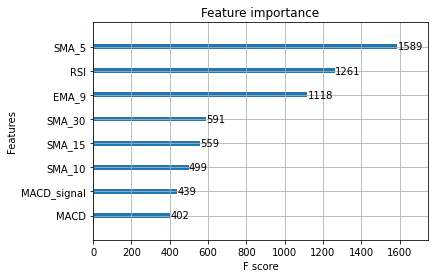

In [16]:
plot_importance(model);

This code generates an importance plot for the trained XGBoost regression model.

The "plot_importance" function is called on the trained model object. This function is specific to XGBoost and is used to visualize the importance of each feature in the model's predictions.

The importance plot provides insights into the relative importance of different features in influencing the model's predictions. It ranks the features based on their contribution to the model's performance and assigns them corresponding importance scores.

By generating this plot, it becomes easier to identify the most influential features and understand their impact on the model's predictions. Features with higher importance scores are considered more influential in determining the output of the model.

In summary, this code generates an importance plot for the XGBoost regression model, allowing for the visualization and interpretation of the relative importance of features in the model's predictions.

Calculate and visualize predictions

In [17]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [31.73 32.84 32.7  32.52 32.37]
y_pred = [30.318808 30.329268 30.484104 30.875212 30.906727]


This code snippet generates predictions using the trained XGBoost regression model and compares them with the actual target values.

The "predict" method is called on the trained model object, passing the test features (X_test) as input. This generates predicted values for the target variable based on the provided test data.

The predicted values are assigned to the variable y_pred, representing the model's predictions for the target variable using the test set.

The "print" function is used to display the actual target values (y_true) from the test set for the first five samples. The np.array function is applied to the y_test variable to convert it into a NumPy array, and the first five values are displayed.

Similarly, the "print" function is used to display the predicted values (y_pred) generated by the model for the first five samples.

By printing the actual and predicted values, it allows for a quick comparison between the model's predictions and the true values. This comparison helps evaluate the model's accuracy and performance in predicting the target variable.

In summary, this code generates predictions using the trained XGBoost regression model and displays the actual target values (y_true) from the test set as well as the corresponding predicted values (y_pred) for the first five samples. This enables a direct comparison between the model's predictions and the true values, providing insights into the accuracy and performance of the model.

In [18]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 3.7443482186887294


This code snippet calculates and prints the mean squared error (MSE) between the actual target values (y_test) and the predicted values (y_pred) obtained from the XGBoost regression model.

The "mean_squared_error" function from scikit-learn is called, passing the actual target values (y_test) and the predicted values (y_pred) as input. This function computes the mean squared error, which is a common metric used to evaluate the performance of regression models.

The result of the mean squared error calculation is displayed using the "print" function. The f-string formatting is used to include the computed mean squared error value in the output message.

By printing the mean squared error, it provides a quantitative measure of the model's prediction accuracy. A lower mean squared error indicates better agreement between the predicted and actual values, suggesting a more accurate model.

In summary, this code calculates the mean squared error between the actual target values and the predicted values from the XGBoost regression model. The resulting mean squared error is then displayed, providing a measure of the model's prediction accuracy.

In [19]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

This code generates a plot to compare the predicted and actual prices of the stock based on the XGBoost regression model.

The first line creates a copy of the DataFrame for the predicted prices, which corresponds to the portion of the original DataFrame after the test split index. This ensures that the original DataFrame remains unchanged.

Next, the 'Close' column of the predicted prices DataFrame is replaced with the predicted values (y_pred) obtained from the model.

A new figure object with two subplots is created using the 'make_subplots' function. Each subplot represents a different aspect of the data visualization.

In the first subplot (row 1, column 1), two scatter traces are added using the 'add_trace' function. The first scatter trace represents the true prices ('Truth') from the original DataFrame, and the second scatter trace represents the predicted prices ('Prediction') from the modified predicted prices DataFrame. Different marker colors are used to differentiate the two traces.

In the second subplot (row 2, column 1), two additional scatter traces are added. One trace represents the true prices ('Truth') from the original test set (y_test), and the other trace represents the predicted prices ('Prediction') from the model (y_pred). The marker colors are consistent with the first subplot, allowing for visual comparison between the predicted and actual values.

Finally, the plot is displayed using the 'show()' function, showing the true and predicted prices in separate subplots for visual analysis and comparison.

In summary, this code generates a plot that displays the true and predicted prices of the stock based on the XGBoost regression model. The plot includes subplots for comparing the true and predicted prices, allowing for visual evaluation of the model's performance.